# W200 Project 2
## Data analysis: Do areas heat up evenly? And is there a discernible difference between warming in the northern and southern hemispheres?

### 1. Introduction
This notebook primarily explores two questions:
- Do different areas around the world experiene global warming to a similar degree?
- Is there a discernible difference in the heating patterns between the northern and southern hemisepheres?

For the first question, the intuition is that the analysis could look into the temperature rise variation against the following variables, namely:
- latitude
- longitude
- presence or amount of water in the neighbourhood of a location

Analysis on the second question will be intertwined with the analysis as we proceed to look at each of the variables above.

For this analysis, the data used will primarily be city-based data from Berkeley Earth.  Such data is chosen over other data such as regional or country-based data primarily because it will be much easier to ascertain if latitude or longitude may have a bearing on the warming pattern.  If country-based data is used, the latitude and longitude data could easily become meaningless for geographically large countries.

In [4]:
# First, let's retrieve the data.  A small pythons script was prepared as usual to generate the following CSV files:
# (i) largest_city_list.csv: essentially contains the tabular information of listed in each of the pages that summarizes the
#                            information for cities starting with a certain alphabet (e.g. for cities starting with 'A', it is:
#                            "http://berkeleyearth.lbl.gov/city-list/A").  Notably, this contains a field called "warming since
#                            1960" which contains the magnitude of warming (in "°C / century") calculated by Berkeley Earth.
# (ii)metadata_largest_city.csv: contains the time-invariant data included in the text file for each individual city, e.g.
#                                for A Coruña, the url is: 
#                                  "http://berkeleyearth.lbl.gov/auto/Local/TAVG/Text/42.59N-8.73W-TAVG-Trend.txt"
#                                Notably, this contains the basline average temperature for each month of the year for the city,
#                                its latitude and longitude, as well as the percentage of water near the city.
# (iii) individual csv for each city: there are 3 523 such files, with each containing the time-based temperature and anomaly
#                                      data.

from codes import webscraper_allcities
# Given the large number of cities involved (totalling 3 523), the code below are just for illustrative purposes, and it
# is recommended that viewers skip directly to the next cell which loads the csv files for use.
webscraper_allcities.generate_city_csv()
webscraper_allcities.generate_metadata_csv()

Handling northern hemisphere...
Handling southern hemisphere...


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# loads the "largest_city_list.csv" and "metadata_largest_city.csv"
city_list = pd.read_csv('data_files/largest_city_list.csv')
metadata = pd.read_csv('data_files/metadata_largest_city.csv', index_col = 'City')

# a fucntion to load the 3 523 individual city csv:
def retrieve_city_data():
    '''
    Reads in all city based csv files.  Run at start of session by default.
    '''
    city_data = {}
    
    for city in city_list.city:
        filename = city + '.csv'
        city_data.update({city: pd.read_csv(filename)})
    
    return city_data

### 2. Sanity checks
This part does some preliminary checks on data quality

In [2]:
# A. Checking the range and number of NaN values of various data sets
print('*' * 10 + "\nChecking data from largest_city_list.csv:\n" + '*' * 10)
for column in list(city_list.columns):
    print(f"\nThe following is the key statistics of column {column}")
    print(f"Maximum value: {city_list[column].max()}")
    print(f"Manimum value: {city_list[column].min()}")
    print(f"Number of NaN values: {len(city_list[city_list[column].isna()])}")
    
# B. Many of cities share the same name.  An attempt was made to modify the names of duplicated cities by adding suffixes
#    (e.g., 1, 2, 3).  This checks if it has worked:
print(f"\nAre there any duplicated city names?: {(city_list['city'].value_counts() > 1).any()}")

# C. Do the same for the metadata data:
print('*' * 10 + "\nChecking data from metadata_largest_city.csv:\n" + '*' * 10)
for column in list(metadata.columns):
    print(f"\nThe following is the key statistics of column {column}")
    print(f"Maximum value: {metadata[column].max()}")
    print(f"Manimum value: {metadata[column].min()}")
    print(f"Number of NaN values: {len(metadata[metadata[column].isna()])}")
print(f"\nAre there any duplicated city names?: {(metadata.index.value_counts() > 1).any()}")

# D. Finally, check if the number and ordering of the cities of the two data frames are the same:
print(f"\nDo the two datasets contain the exact same cities in the same order?: {(list(city_list.city) == list(metadata.index))}")

**********
Checking data from largest_city_list.csv:
**********

The following is the key statistics of column Unnamed: 0
Maximum value: 3522
Manimum value: 0
Number of NaN values: 0

The following is the key statistics of column city
Maximum value: Ürümqi
Manimum value: A Coruña
Number of NaN values: 0

The following is the key statistics of column country
Maximum value: Zimbabwe
Manimum value: Afghanistan
Number of NaN values: 0

The following is the key statistics of column temp
Maximum value: 4.31 ± 0.32
Manimum value: 0.43 ± 0.48
Number of NaN values: 0

The following is the key statistics of column warming_since_1960
Maximum value: 4.31
Manimum value: 0.43
Number of NaN values: 0

The following is the key statistics of column uncertainty
Maximum value: 1.33
Manimum value: 0.1
Number of NaN values: 0

The following is the key statistics of column location
Maximum value: 8.84S-78.65W
Manimum value: 0.80N-103.66E
Number of NaN values: 0

Are there any duplicated city names?: False
*

So, the data from the two CSV files look fine!

### 3. Do different areas around the world experiene global warming to a similar degree?
As mentioned above, this part will look at the variation of global warming patterns having regard to the following characteristics of each location:

- latitude
- longitude
- presence or amount of water in the neighbourhood of a location

To facilitate the analysis and data plotting, a single data frame containing all 3 523 cities along with their (i) latitude, (ii) longitude, (iii) Neighborhood_water_percent, and (iv) warming_since_1960 will be compiled.  In addition, we will add in columns to label the cities based on:
- northern/southern hemisepheres: based on positive/negative latitude
- tropical/sub-tropical/temperate/frigid zones: based on absolute value of latitude (cut-off points at 23.43644°/35°/66.5°)
- natural timezones: based on longitude, divided into 24 categories

The following cell does the data treatment.

In [3]:
# base data with all needed columns included
base_data = metadata.copy()
base_data['Warming_since_1960'] = city_list.set_index('city').warming_since_1960

# adds the north/south hemisphere categorization
base_data['Hemisphere'] = 'north'
base_data.loc[base_data.Latitude < 0, 'Hemisphere'] = 'south'

# adds the tropical/sub-tropical/temperate/frigid zones categorization
base_data['Climate_zone'] = 'tropical'
base_data.loc[(base_data.Latitude < -23.43644) | (base_data.Latitude > 23.43644), 'Climate_zone'] = 'sub-tropical'
base_data.loc[(base_data.Latitude < -35) | (base_data.Latitude > 35), 'Climate_zone'] = 'temperate'
base_data.loc[(base_data.Latitude < -66.5) | (base_data.Latitude > 66.5), 'Climate_zone'] = 'frigid'

# adds the natural time zones.
base_data['Natural_time_zone'] = 'UTC'
for i in range(12):
    base_data.loc[(base_data.Longitude < (-7.5 - 15 * i)), 'Natural_time_zone'] = 'UTC-' + str(i+1)
    base_data.loc[(base_data.Longitude > (7.5 + 15 * i)), 'Natural_time_zone'] = 'UTC+' + str(i+1)
    
print("Showing the value counts of the added columns")
for column in ['Hemisphere', 'Climate_zone', 'Natural_time_zone']:
    print(f"\nThe following is the value counts of column {column}:")
    print(f"{base_data[column].value_counts()}")

Showing the value counts of the added columns

The following is the value counts of column Hemisphere:
north    2907
south     616
Name: Hemisphere, dtype: int64

The following is the value counts of column Climate_zone:
tropical        1376
temperate       1249
sub-tropical     896
frigid             2
Name: Climate_zone, dtype: int64

The following is the value counts of column Natural_time_zone:
UTC+8     395
UTC+5     385
UTC       320
UTC+2     306
UTC+1     295
UTC+7     295
UTC-5     235
UTC+9     201
UTC-3     184
UTC+3     181
UTC+6     171
UTC-6     127
UTC-7     115
UTC-8      89
UTC-4      79
UTC+4      64
UTC-1      36
UTC-2      18
UTC+10     16
UTC+12      7
UTC+11      3
UTC-10      1
Name: Natural_time_zone, dtype: int64


The above also has the effect of giving us a first glimpse of the distribution of these cities.  Most are in the northern hemisphere, though there are also a significant number of data points from the south to hopefully provide some insights.

The distribution among the tropical, sub-tropical and temperate zones also look rather even.  However, given the small number of samples from the frigid zone, the graph plotting below will merge the temperate and frigid as one group.

The distribution across 'natural time zones" also seem expected, with UTC + 8 (Southeast Asia covering coastal China, the Philippines, a large part of Indonesia) and UCT+5 (South/Central Asia, covering large parts of India, Pakistan and some of Afghanistan) topping the charts

See the image below which shows the actual (i.e. not "natural") time zones for a comparison:
<img src="graphs/World_Time_Zones_Map.png" align="left" width="1000" height="500" />

### 4. Graph plotting (Part 1)
(i) Plotting of temperature rise since 1960 against latitude

<ipython-input-6-e4e8e9961236>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  southhem_data['Latitude'] = abs(southhem_data.Latitude)


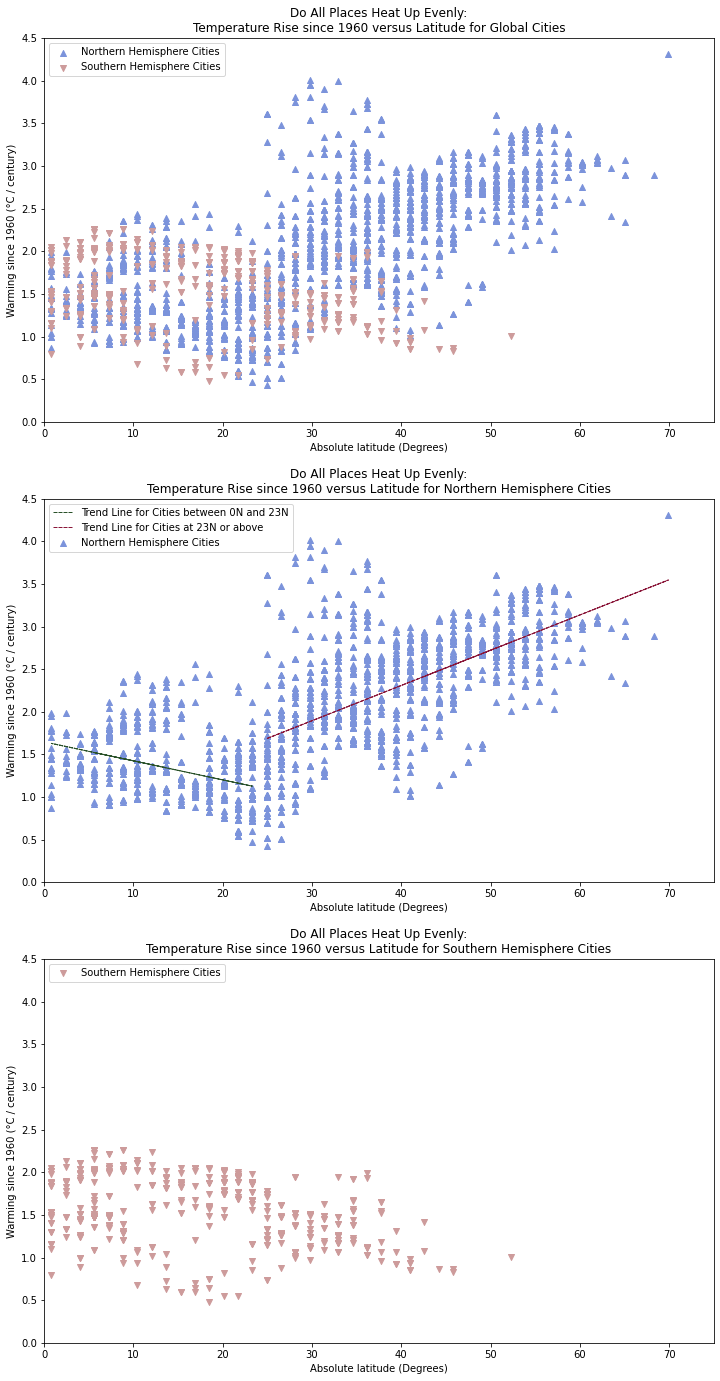

In [6]:
fig = plt.figure(figsize=(12,24))
ax1, ax2, ax3 = fig.add_subplot(3,1,1), fig.add_subplot(3,1,2), fig.add_subplot(3,1,3)

northhem_data = base_data[base_data.Hemisphere == 'north']
southhem_data = base_data[base_data.Hemisphere == 'south']
southhem_data['Latitude'] = abs(southhem_data.Latitude)

# ax1 shows both hemispheres, ax2 just northern, ax3 just southern
for ax in (ax1, ax2):
    ax.scatter(northhem_data.Latitude, northhem_data.Warming_since_1960, c="#7B93DB", marker="^", label="Northern Hemisphere Cities")
for ax in (ax1, ax3):
    ax.scatter(southhem_data.Latitude, southhem_data.Warming_since_1960, c="#CD9B9B", marker="v", label="Southern Hemisphere Cities")

## Adding a trend line for tropical zones for norther hemisphere
z1 = np.polyfit(northhem_data[northhem_data.Climate_zone == 'tropical'].Latitude,
               northhem_data[northhem_data.Climate_zone == 'tropical'].Warming_since_1960, 1)
p1 = np.poly1d(z1)
ax2.plot(northhem_data[northhem_data.Climate_zone == 'tropical'].Latitude, 
        p1(northhem_data[northhem_data.Climate_zone == 'tropical'].Latitude), 
        c="#2a522a", linewidth=1, label="Trend Line for Cities between 0N and 23N",
        linestyle = (0,(4,1)))


## Adding a trend line for non-tropical zones for norther hemisphere
z2 = np.polyfit(northhem_data[northhem_data.Climate_zone != 'tropical'].Latitude,
               northhem_data[northhem_data.Climate_zone != 'tropical'].Warming_since_1960, 1)
p2 = np.poly1d(z2)
ax2.plot(northhem_data[northhem_data.Climate_zone != 'tropical'].Latitude, 
        p2(northhem_data[northhem_data.Climate_zone != 'tropical'].Latitude), 
        c="#8a1639", linewidth=1, label="Trend Line for Cities at 23N or above",
        linestyle = (0,(4,1)))

titles = {ax1: "Global Cities",
         ax2: "Northern Hemisphere Cities",
         ax3: "Southern Hemisphere Cities"}

for ax in (ax1, ax2, ax3):
    ax.set_xlabel("Absolute latitude (Degrees)")
    ax.set_ylabel("Warming since 1960 (°C / century)")
    ax.set_title(f"Do All Places Heat Up Evenly:\nTemperature Rise since 1960 versus Latitude for {titles[ax]}")
    ax.set_ylim(0, 4.5)
    ax.set_xlim(0, 75)
    ax.legend(loc=2)

#### Observation 1:
- Heating in northern hemisphere is more noticeable, and shows a trend of increasing warming rate as one goes north beyond the tropical zones.
- For the southern hemisphere, the warming rate is noticeably lower and does not show significant variation as one goes south.
- This was also observed during the preliminary analyis of the project proposal stage, and there was a question on whether this could have been caused by the small number and range of data points from the southern hemisphere.
- But as we expend the data range for the southern hemisphere, it seems the pattern still hold.

### 4. Graph plotting (Part 2)
(ii) Given the presence of some outlier groups for the northern hemisphere cities (at latitudes of around (a) 8 to 20N; and (b) 25N to 40N), let's see if combining a longitudinal grouping (i.e. using the "natural time zone" categories) will help shed some light on what these data points are.  The idea is that a group based on latitude and longitude should indicate the general region the data points are in.

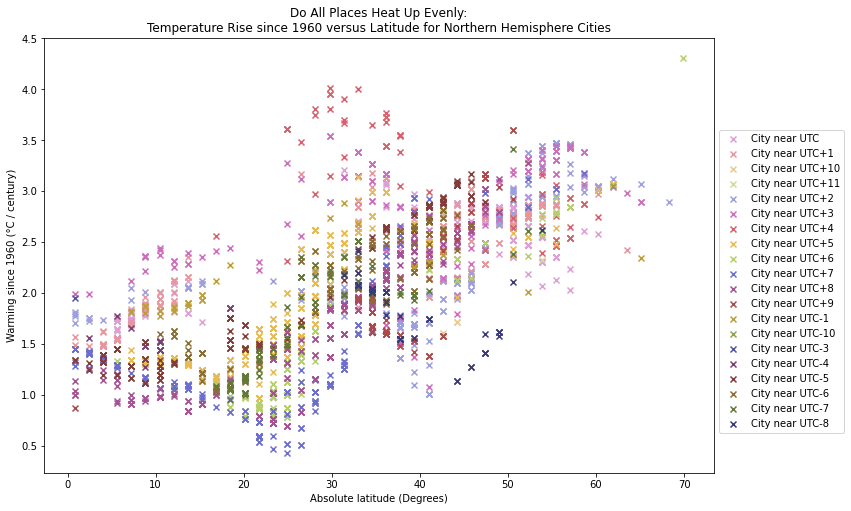

In [7]:
# creates a groupby object
by_timezone = northhem_data.groupby('Natural_time_zone')

fig2 = plt.figure(figsize=(12,8))
ax4 = fig2.add_subplot(1,1,1)
cmap = plt.get_cmap("tab20b_r")
mixer = ([4*i for i in range(5)] + [4*i + 1 for i in range(5)] 
         + [4*i + 2 for i in range(5)] + [4*i + 3 for i in range(5)])
i = 0

for name, group in by_timezone:    
    grouped_data = by_timezone.get_group(name).loc[:, ['Latitude', 'Warming_since_1960']]
    ax4.scatter(grouped_data.Latitude, grouped_data.Warming_since_1960,
                c=colors.to_hex(cmap(mixer[i])), marker="x", label="City near " + name)
    i += 1

ax4.set_xlabel("Absolute latitude (Degrees)")
ax4.set_ylabel("Warming since 1960 (°C / century)")
ax4.set_title(f"Do All Places Heat Up Evenly:\nTemperature Rise since 1960 versus Latitude for Northern Hemisphere Cities")
ax4.legend(bbox_to_anchor=(1.0, 0.8))

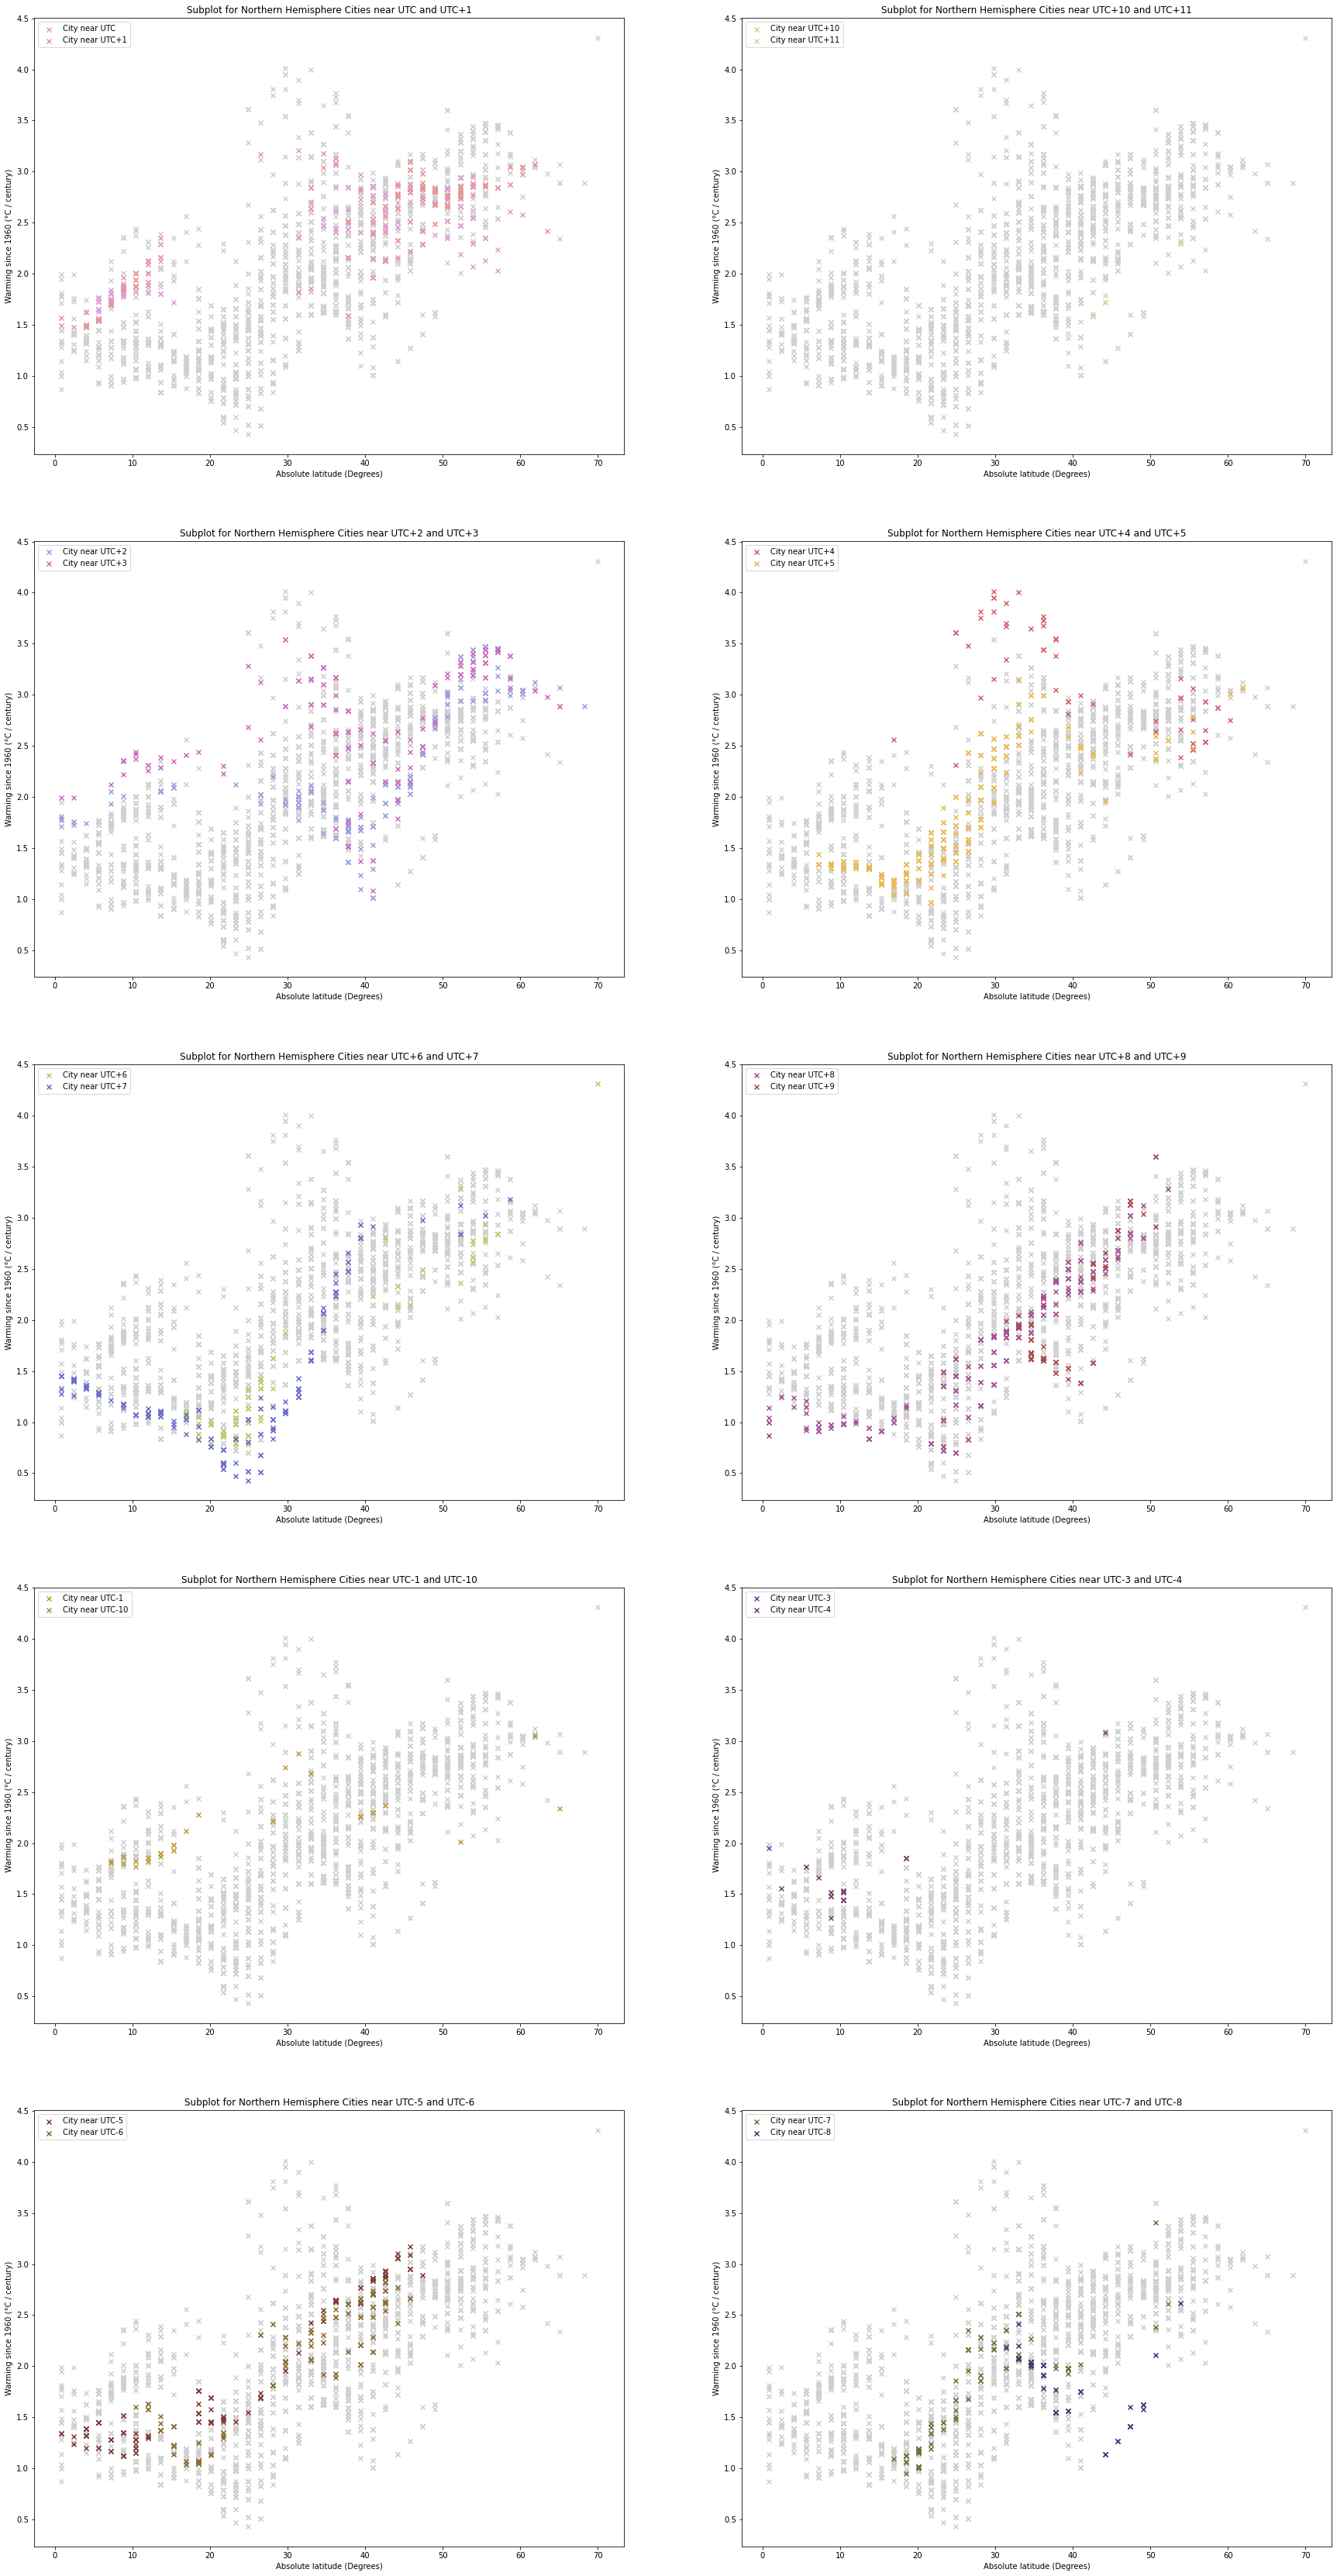

In [204]:
fig3, ax5 = plt.subplots(5, 2, figsize=(30,60))

# compile a dictionary mapping each subplots to two natural time zones.
# Note that there are only 20 as opposed to 24 natural time zones for the northern hemisphere.
# Missing timezones are mostly oceanic or sparsely populated areas in the northern hemisphere.
plotting_dict = {list(ax5.reshape(-1))[i]: 
                 (list(by_timezone.groups.keys())[2*i], list(by_timezone.groups.keys())[2*i + 1]) 
                 for i in range(len(list(ax5.reshape(-1))))}

cmap = plt.get_cmap("tab20b_r")
i = 0

for axes in plotting_dict:
    zone1, zone2 = plotting_dict[axes]
    grouped_data1 = by_timezone.get_group(zone1).loc[:, ['Latitude', 'Warming_since_1960']]
    grouped_data2 = by_timezone.get_group(zone2).loc[:, ['Latitude', 'Warming_since_1960']]
    basedata = northhem_data[(northhem_data.Natural_time_zone != zone1) &
                             (northhem_data.Natural_time_zone != zone2)]
    
    axes.scatter(basedata.Latitude, basedata.Warming_since_1960, c="#cfcfcf", marker="x")
    axes.scatter(grouped_data1.Latitude, grouped_data1.Warming_since_1960, 
                 c=colors.to_hex(cmap(mixer[i])),
                 marker="x", label="City near " + zone1)
    i += 1
    axes.scatter(grouped_data2.Latitude, grouped_data2.Warming_since_1960, 
                 c=colors.to_hex(cmap(mixer[i])),
                 marker="x", label="City near " + zone2)
    i += 1

    axes.set_xlabel("Absolute latitude (Degrees)")
    axes.set_ylabel("Warming since 1960 (°C / century)")
    axes.set_title(f"Subplot for Northern Hemisphere Cities near {zone1} and {zone2}")
    axes.legend(loc=2)

#### Observation 2: Outliers observed from northern hemisphere
Given the above, it seems the outliers are indeed from a particular region, specifically areas from
the UTC+4 and UCT+3 areas for the sub-tropical zones.  Lets take a look at what these cities and countries are.

Text(0, 0.5, 'Number of outlier cities')

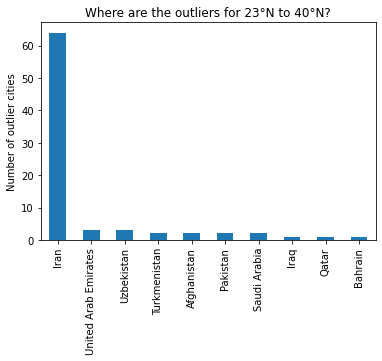

In [98]:
# Let's check the UTC + 4 countries
UTC4_outliers = northhem_data[(northhem_data.Natural_time_zone == 'UTC+4') 
                              & (northhem_data.Latitude > 23.43644)
                              & (northhem_data.Latitude <= 40)
                              & (northhem_data.Warming_since_1960 > 2.5)].reset_index().City
UTC3_outliers = northhem_data[(northhem_data.Natural_time_zone == 'UTC+3') 
                              & (northhem_data.Latitude > 23.43644)
                              & (northhem_data.Latitude <= 40)
                              & (northhem_data.Warming_since_1960 > 2.5)].reset_index().City

# Preparing lists showing the countries with outliers
l1 = pd.DataFrame(city_list[city_list.city.isin(UTC4_outliers)].country.value_counts())
l2 = pd.DataFrame(city_list[city_list.city.isin(UTC3_outliers)].country.value_counts())
l3 = pd.concat([l1, l2], axis=1, join="outer").fillna(0)
l3.columns = ['Cities in UTC+4', 'Cities in UTC+3']
l3['Total'] = l3['Cities in UTC+4'] + l3['Cities in UTC+3']
l3

# Plotting a bar chart showing the countries with outliers
ax = l3['Total'].plot.bar(title = 'Where are the outliers for 23°N to 40°N?', )
ax.set_ylabel("Number of outlier cities")

Text(0, 0.5, 'Number of outlier cities')

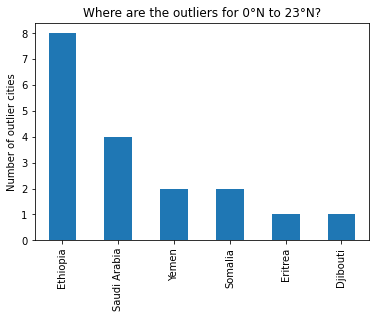

In [99]:
UTC3_outliers2 = northhem_data[(northhem_data.Natural_time_zone == 'UTC+3') 
                              & (northhem_data.Latitude > 0)
                              & (northhem_data.Latitude <= 23.43644)
                              & (northhem_data.Warming_since_1960 > 2.0)].reset_index().City

# Preparing lists showing the countries with outliers
l4 = pd.DataFrame(city_list[city_list.city.isin(UTC3_outliers2)].country.value_counts())
l4.columns = ['Cities in UTC+3']

# Plotting a bar chart showing the countries with outliers
ax = l4.plot.bar(title = 'Where are the outliers for 0°N to 23°N?', legend=False)
ax.set_ylabel("Number of outlier cities")

In [73]:
# Let's check the UTC + 4 countries
print("These are the outlier cities in the UTC+4 natural time zones:")
UTC4_outliers = northhem_data[(northhem_data.Natural_time_zone == 'UTC+4') 
                              & (northhem_data.Latitude > 23.43644)
                              & (northhem_data.Latitude <= 40)
                              & (northhem_data.Warming_since_1960 > 2.5)].reset_index().City
print(UTC4_outliers)
print("\nAnd they belong to these countries:")
print(list(city_list[city_list.city.isin(UTC4_outliers)].country.unique()))

These are the outlier cities in the UTC+4 natural time zones:


array(['United Arab Emirates', 'Turkmenistan', 'Iran', 'Afghanistan',
       'Pakistan', 'Uzbekistan'], dtype=object)

In [174]:
# And the UTC + 3 countries
print("These are the outlier cities in the UTC+3 natural time zones:")
UTC3_outliers = northhem_data[(northhem_data.Natural_time_zone == 'UTC+3') 
                              & (northhem_data.Latitude > 23.43644)
                              & (northhem_data.Latitude <= 40)
                              & (northhem_data.Warming_since_1960 > 2.5)].reset_index().City
print(UTC3_outliers)
print("\nAnd they belong to these countries:")
print(list(city_list[city_list.city.isin(UTC3_outliers)].country.unique()))

These are the outlier cities in the UTC+3 natural time zones:
0                Abadan
1                 Ahvaz
2                  Amol
3                  Arak
4               Ardabil
5                 Babol
6               Baghdad
7       Bandar-e Anzali
8                 Baneh
9              Borujerd
10                Bukan
11             Buraydah
12              Bushehr
13               Dezful
14               Do Rud
15                 Doha
16              Esfahan
17           Eslamshahr
18              Hamadan
19                 Ilam
20                Karaj
21               Kashan
22           Kermanshah
23        Khomeynishahr
24          Khorramabad
25         Khorramshahr
26             Kuhdasht
27              Mahabad
28               Manama
29             Maragheh
30               Marand
31              Marivan
32    Masjed-e Soleyman
33             Miandoab
34             Parsabad
35              Qarchak
36               Qazvin
37                  Qom
38                Rasht
39

In [71]:
# And the UTC + 3 countries for lower latitudes
print("These are the outlier cities in the UTC+3 natural time zones:")
UTC3_outliers = northhem_data[(northhem_data.Natural_time_zone == 'UTC+3') 
                              & (northhem_data.Latitude > 0)
                              & (northhem_data.Latitude <= 23.43644)
                              & (northhem_data.Warming_since_1960 > 2.0)].reset_index().City
print(UTC3_outliers)
print("\nAnd they belong to these countries:")
print(list(city_list[city_list.city.isin(UTC3_outliers)].country.unique()))

These are the outlier cities in the UTC+3 natural time zones:
0            Abha
1     Addis Abeba
2            Aden
3          Asmara
4          Awassa
5       Bahir Dar
6         Berbera
7     Debre Zeyit
8            Dese
9       Dire Dawa
10         Gondar
11       Hargeysa
12            Ibb
13         Jibuti
14         Jiddah
15          Mecca
16         Najran
17         Nazret
Name: City, dtype: object

And they belong to these countries:
['Saudi Arabia', 'Ethiopia', 'Yemen', 'Eritrea', 'Somalia', 'Djibouti']


#### Observation 3: Some findings from the longitudinal plus latitude analysis:
Based on the above, a few norther hermisphere countries appears to be outliers in terms of their warming since 1960 figures, having regard to the latitude:
 - Afghanistan
 - Bahrain
 - Iran
 - Iraq
 - Pakistian
 - Qatar
 - Saudi Arabia
 - Turkmenistan
 - United Arab Emirates
 - Uzbekistan

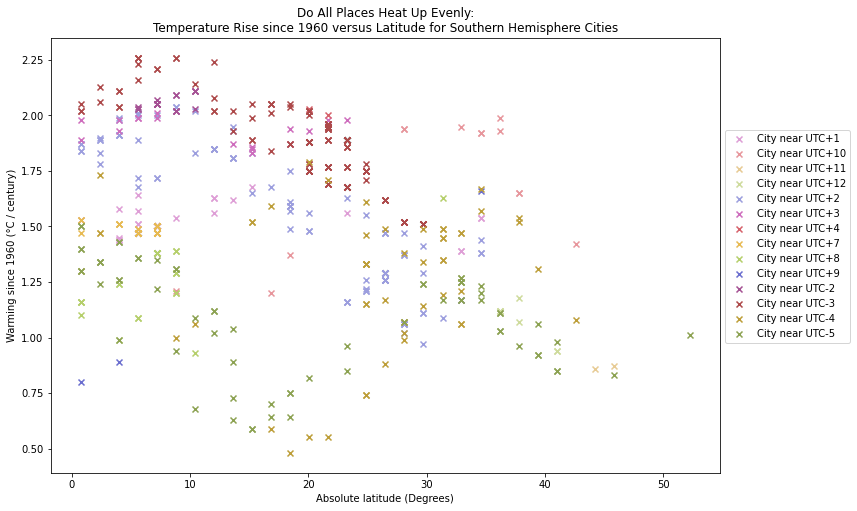

In [176]:
# longitudinal analysis for southern hemisphere.  This just shows there aren't any obvious patterns
by_timezone2 = southhem_data.groupby('Natural_time_zone')

fig4 = plt.figure(figsize=(12,8))
ax6 = fig4.add_subplot(1,1,1)
cmap = plt.get_cmap("tab20b_r")
mixer = ([4*i for i in range(5)] + [4*i + 1 for i in range(5)] 
         + [4*i + 2 for i in range(5)] + [4*i + 3 for i in range(5)])
i = 0

for name, group in by_timezone2:    
    grouped_data = by_timezone2.get_group(name).loc[:, ['Latitude', 'Warming_since_1960']]
    ax6.scatter(grouped_data.Latitude, grouped_data.Warming_since_1960,
                c=colors.to_hex(cmap(mixer[i])), marker="x", label="City near " + name)
    i += 1

ax6.set_xlabel("Absolute latitude (Degrees)")
ax6.set_ylabel("Warming since 1960 (°C / century)")
ax6.set_title(f"Do All Places Heat Up Evenly:\nTemperature Rise since 1960 versus Latitude for Southern Hemisphere Cities")
ax6.legend(bbox_to_anchor=(1.0, 0.8))

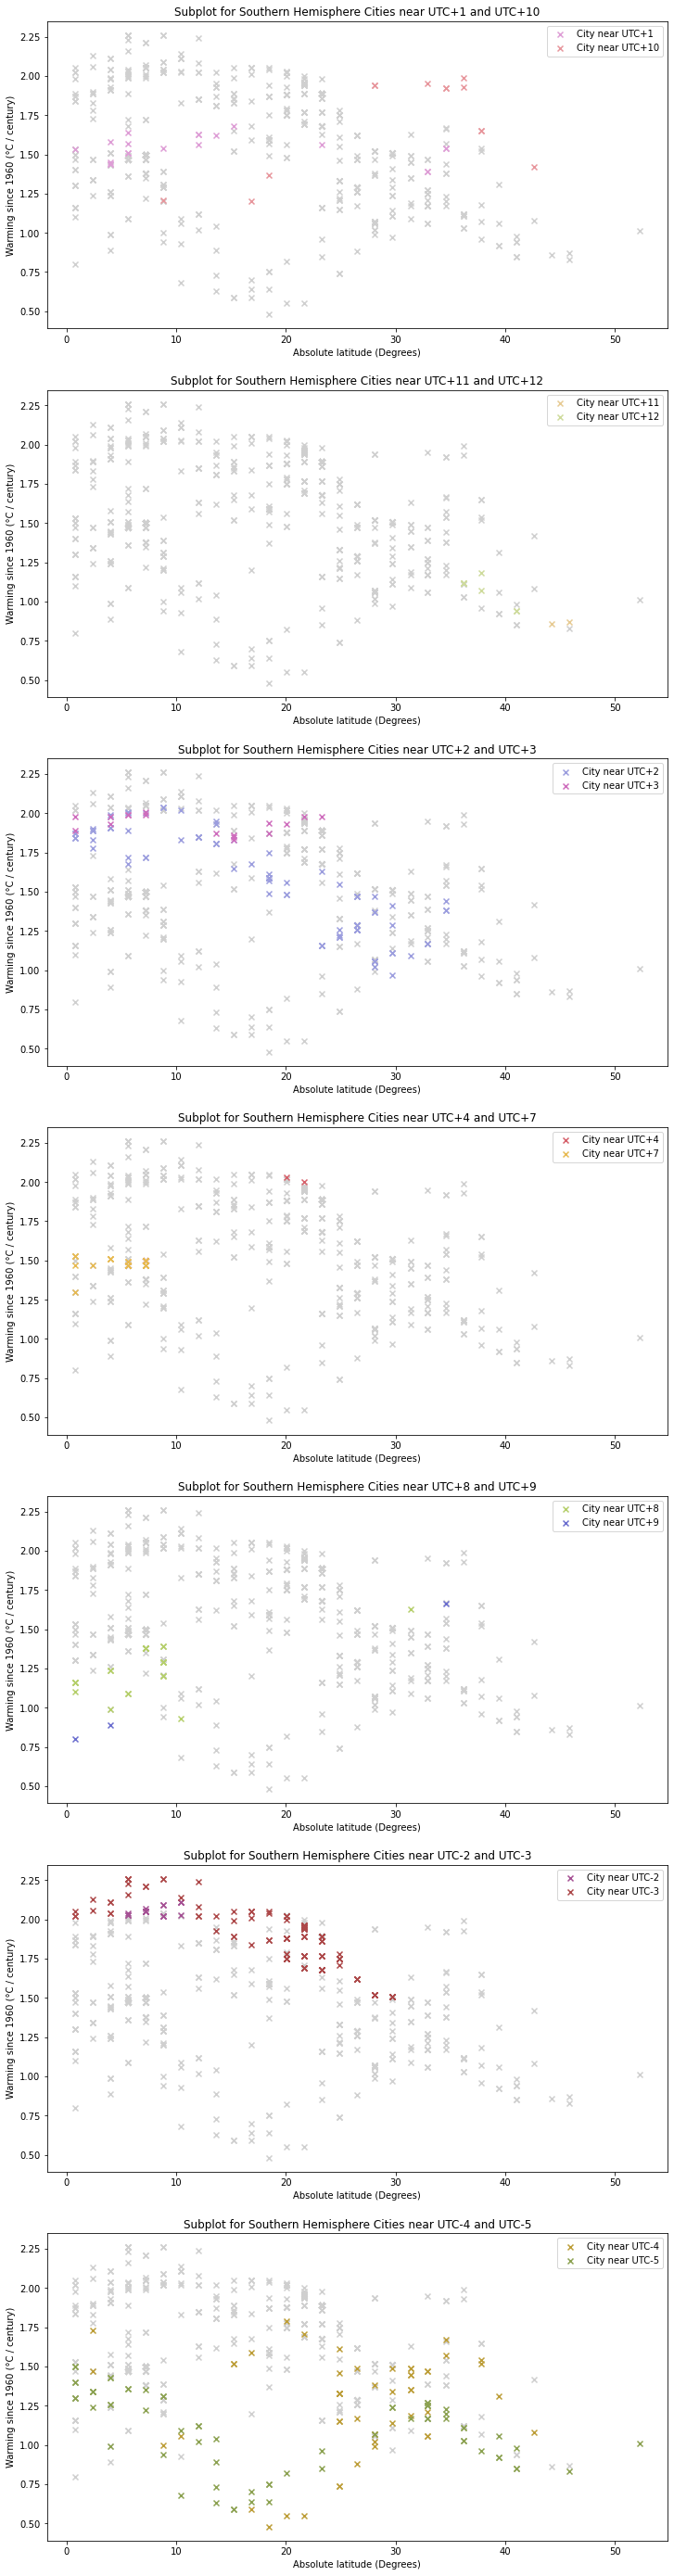

In [200]:
fig5, ax6 = plt.subplots(7, 1, figsize=(12,50))
fig5.subplots_adjust(hspace = 0.2)

# compile a dictionary mapping each subplots to two natural time zones.
# Note that there are only 20 as opposed to 24 natural time zones for the northern hemisphere.
# Missing timezones are mostly oceanic or sparsely populated areas in the northern hemisphere.
plotting_dict2 = {ax6[i]: (list(by_timezone2.groups.keys())[2*i], list(by_timezone2.groups.keys())[2*i + 1]) 
                 for i in range(len(ax6))}

cmap = plt.get_cmap("tab20b_r")
i = 0

for axes in plotting_dict2:
    zone1, zone2 = plotting_dict2[axes]
    grouped_data1 = by_timezone2.get_group(zone1).loc[:, ['Latitude', 'Warming_since_1960']]
    grouped_data2 = by_timezone2.get_group(zone2).loc[:, ['Latitude', 'Warming_since_1960']]
    basedata = southhem_data[(southhem_data.Natural_time_zone != zone1) &
                             (southhem_data.Natural_time_zone != zone2)]
    
    axes.scatter(basedata.Latitude, basedata.Warming_since_1960, c="#cfcfcf", marker="x")
    axes.scatter(grouped_data1.Latitude, grouped_data1.Warming_since_1960, 
                 c=colors.to_hex(cmap(mixer[i])),
                 marker="x", label="City near " + zone1)
    i += 1
    axes.scatter(grouped_data2.Latitude, grouped_data2.Warming_since_1960, 
                 c=colors.to_hex(cmap(mixer[i])),
                 marker="x", label="City near " + zone2)
    i += 1

    axes.set_xlabel("Absolute latitude (Degrees)")
    axes.set_ylabel("Warming since 1960 (°C / century)")
    axes.set_title(f"Subplot for Southern Hemisphere Cities near {zone1} and {zone2}")
    axes.legend(loc=1)

#### Observation 4: As for the southern hemisphere:
It seems the same cannot be said for the south.  There are some regional groupings, but there are no clear outliers.  In fact, the general heating level seems to be lower for the southern hemisphere

### 4. Graph plotting (Part 3)
(iii) This part looks at the effect of having water bodies near a city.

Text(0.5, 1.0, "Presence of Water Doesn't Seem to Alleviate Heating:\nTemperature Rise versus Percentage of Water Near City")

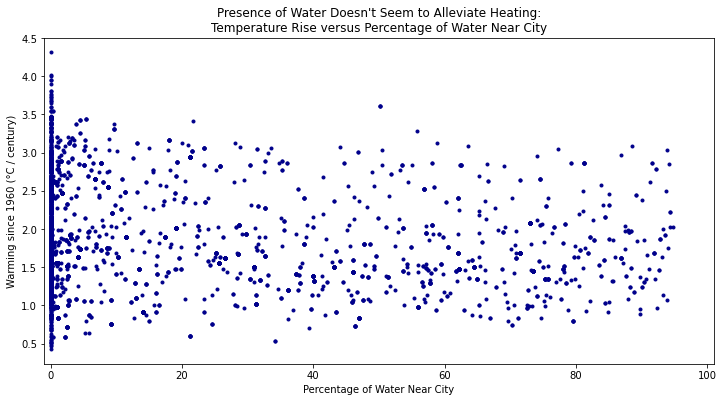

In [109]:
fig6 = plt.figure(figsize=(12,6))
ax7 = fig6.add_subplot(1,1,1)

water = base_data.copy()
water['WaterContent'] = water.Neighborhood_water_percent * 100

ax7.scatter(water.WaterContent, water.Warming_since_1960, c="#00008B", marker=".")

ax7.set_xlabel("Percentage of Water Near City", fontsize = 10)
ax7.set_xlim(-1, 101)
ax7.set_ylabel("Warming since 1960 (°C / century)", fontsize = 10)
ax7.set_title("Presence of Water Doesn't Seem to Alleviate Heating:\nTemperature Rise versus Percentage of Water Near City",
             fontsize = 12)


#### Observation 5: Water has negligible effect on warming rates
It seems the presence of water near a city do not have a noticeable effect on the warming rate.